## Modulos

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

## Carga imagen y visualización

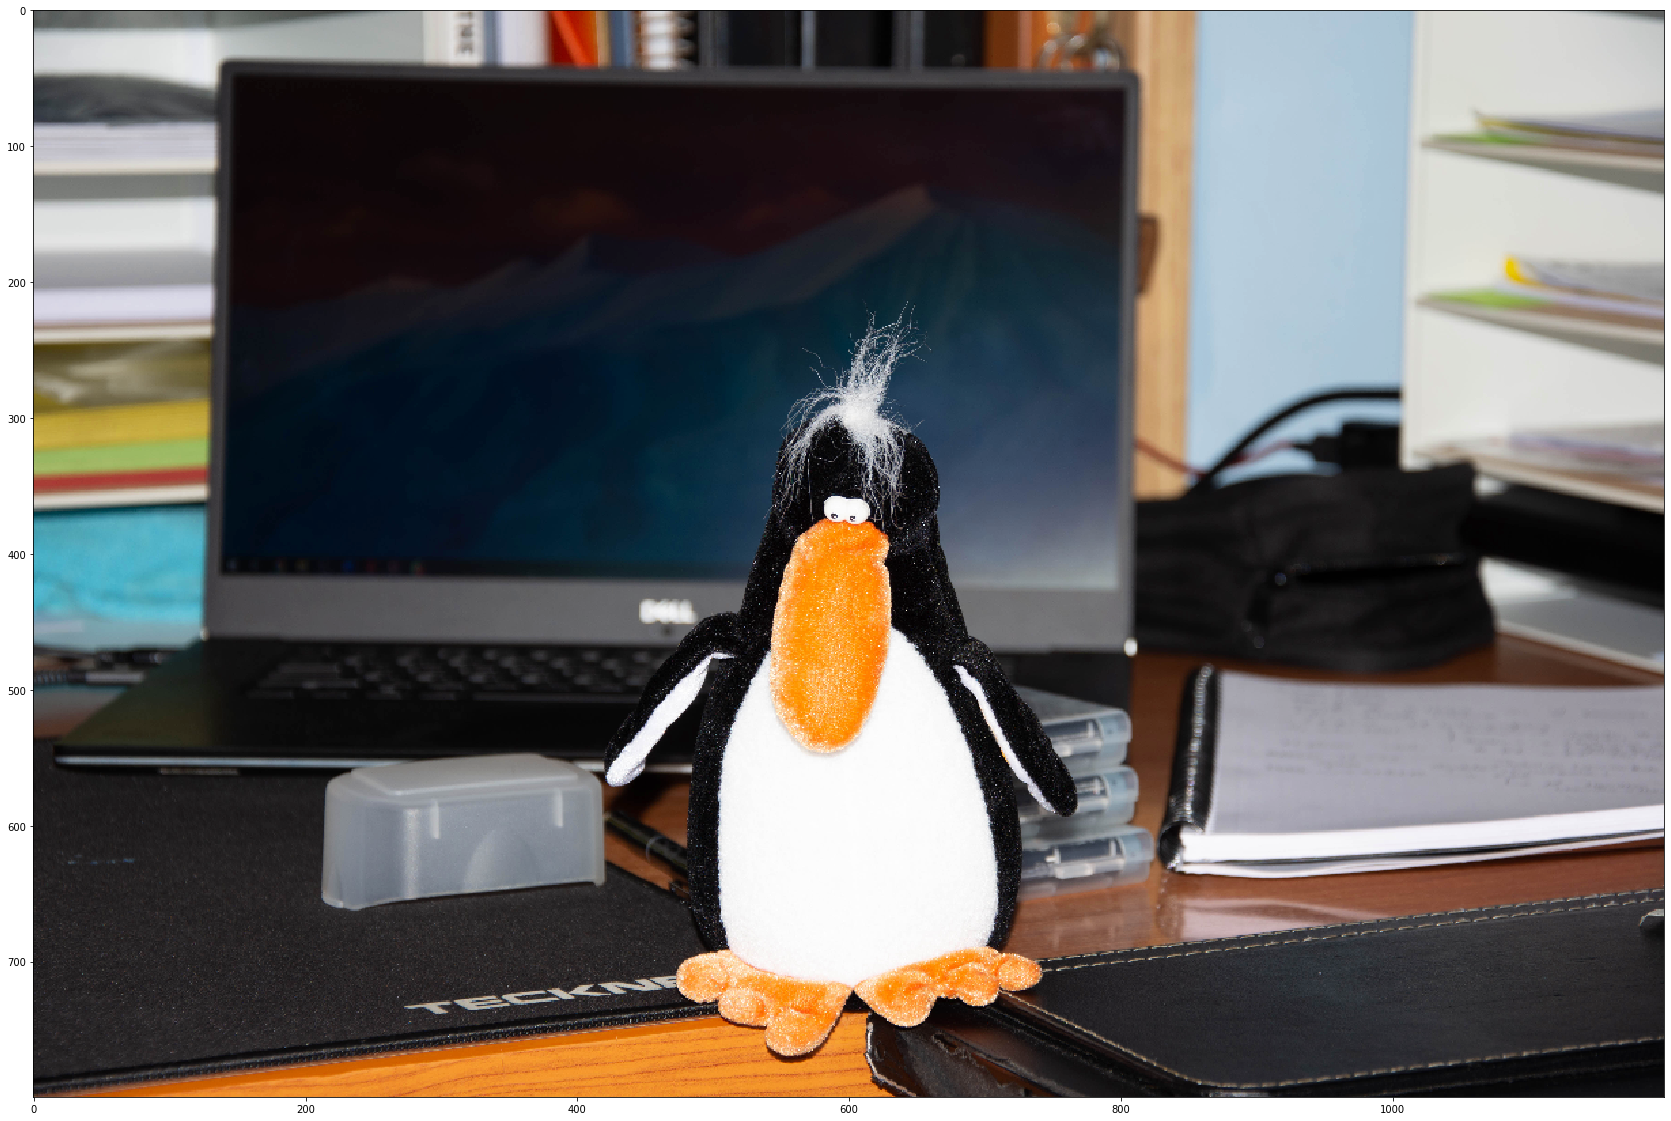

In [2]:
# Imgfile='./IMAGES/304baf26742db277bf48c524b3fd1f29.jpg'  #Posible
# Imgfile='./IMAGES/Before-After.jpg'                      #meh
# Imgfile='./IMAGES/download.jpg'                          # muy baja calidad
# Imgfile='./IMAGES/flash-blown-out.jpg'                   # bastante quemada
# Imgfile='./IMAGES/flash-blow-out.jpg'                    #Irrecuperable
# Imgfile='./IMAGES/lucio-and-i-bad-lighting.jpg'          #Amarillento
Imgfile='./IMAGES/Propias/jpg/ARA_9558.jpg'
# Imgfile='./IMAGES/Propias/jpg/ARA_9557.jpg'

def norm_hsv(img):
    """
    Normaliza una imagen HSV. La pasa el canal del brillo de 0-255 en np.uint8 a 0-1 en float
    """
    out=np.copy(img.astype(float))
    out[:,:,2]=img[:,:,2]/255
    return out
def denorm_hsv(img):
    """
    Operazion inversa a norm_hsv(). Devulve la imagen HSV en np.uint8 con H de 0-179 S de 0-255 y V de 0-255 (formato estandar de cv2)
    """
    out=np.copy(img)
    out[:,:,2]=img[:,:,2]*255
    return out.astype(np.uint8)

def load_img(file,resize=(1200,800),show=True):
    """
    Carga la imagen suministrada (path) y devuelve la imagen en HSV normalizada (brillo de 0 a 1). Se muestra la imagen al cargarla
    """

    img=cv2.imread(Imgfile,cv2.IMREAD_COLOR)  #Cargar imagen (lo hace en BGR)
    
    if resize==False:
        pass
    else:
        img=cv2.resize(img,resize)           #Reducir el tamaño si la imagen es grande
        
    HSVimg = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    if show:
        fig, axs = plt.subplots(figsize=(30,20))
        plt.imshow(cv2.cvtColor(HSVimg,cv2.COLOR_HSV2RGB))
    
    return norm_hsv(HSVimg)

img=load_img(Imgfile)

## Visualización zonas en el X%

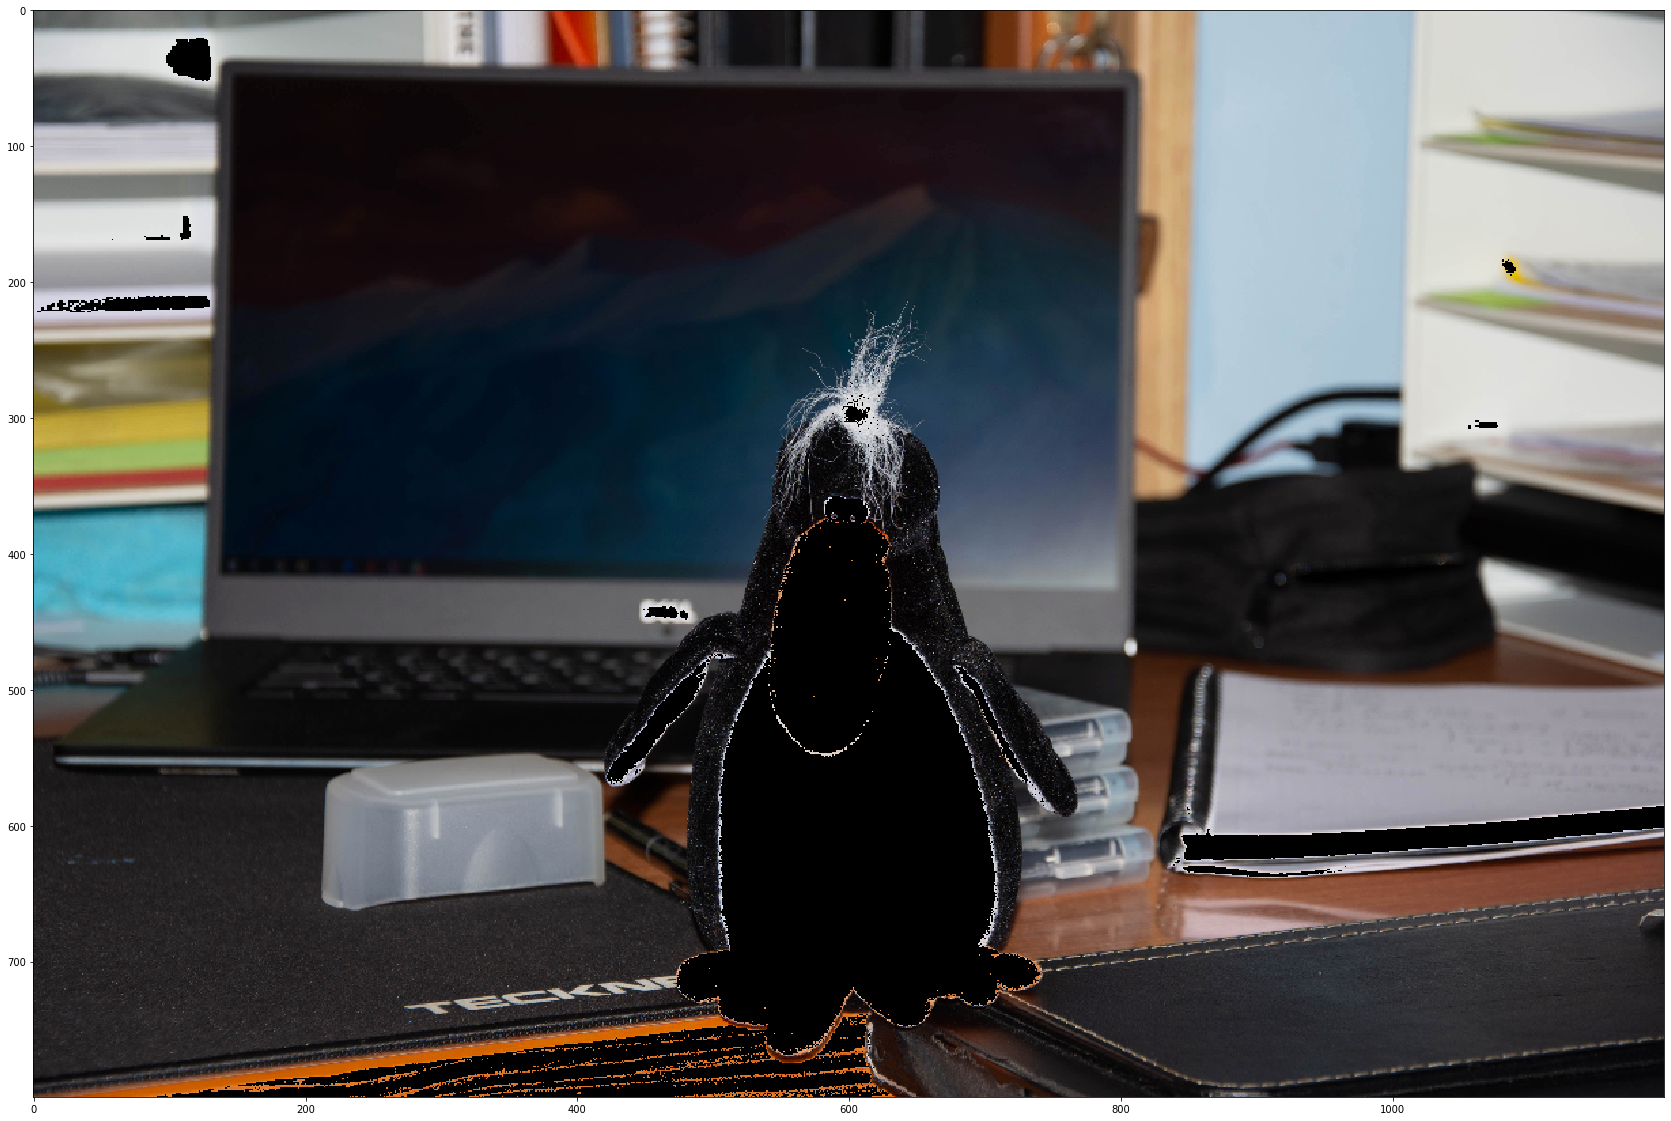

In [3]:
def show_over(img,threshold):
    """
    Muestra la parte de la imagen que se pasa de un cierto porcentaje de intensidad.
    La intensidad va de 0 a 1, por lo que threshold tambien.
    """
    img[:,:,2]=np.where(img[:,:,2]>0.9, 0, img[:,:,2])
    fig, axs = plt.subplots(figsize=(30,20))
    plt.imshow(cv2.cvtColor(denorm_hsv(img), cv2.COLOR_HSV2RGB))

img=load_img(Imgfile,show=False)
show_over(img,0.9)

# Transformación

Para que sea más modular el codigo, defino una serie de kernels que son los que llevan a cabo la transformación puntual y una función que utiliza los kernels para hacer la transformación.

###  Kernels

In [4]:
def kernel_doble_recta(valor,xc,yc):
    """
    Xc y Yc son las cordenadas del punto donde se unen las rectas.
    """
    if valor<xc:
        m=yc/xc
        out=valor*m
    else:
        m=(yc-1)/(xc-1)
        n=1-m
        out=valor*m+n
    return out

def kernel_exp(valor,alpha,max_r,max_s):
    """
    max_r es el valor maximo de entrada y max_s el de salida. Alpha más alto mayor es el efecto de reducción de brillo.
    """
    c=max_s/((1+alpha)**max_r-1)
    out=c*((1+alpha)**valor-1)
    return out

def kernel_log(valor,alpha,max_r,max_s):
    """
    max_r es el valor maximo de entrada y max_s el de salida. Alpha más alto mayor es el efecto de aumento de brillo.
    """
    c=max_s/np.log(1+(math.exp(alpha)-1)*max_r)
    out=c*np.log(1+(math.exp(alpha)-1)*valor)
    return out
                   
def kernel_exp_recta(valor,alpha,inicio_r,inicio_s,max_r,max_s):
    """
    Similar al kernel exponencial, pero se combina con la transformación identidad
    """
    c=(max_s-inicio_s)/((1+alpha)**(max_r-inicio_r)-1)
    if valor<inicio_r:
        m=inicio_s/inicio_r
        out=valor*m
    else:
        out=c*((1+alpha)**(valor-inicio_r)-1)+inicio_s
    return out

### Visualizar kernels

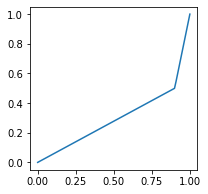

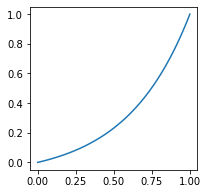

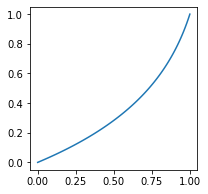

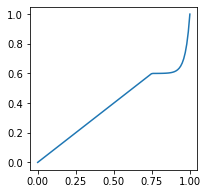

In [5]:
def show_kernel(kernel,*args):
    r=np.linspace(0,1,100)
    s=np.array([kernel(i,*args) for i in r])
    fig, axs = plt.subplots(figsize=(3,3))
    plt.plot(r,s)
    
show_kernel(kernel_doble_recta,0.9,0.5)
show_kernel(kernel_exp,10,1,1)
show_kernel(kernel_log,-2,1,1)
show_kernel(kernel_exp_recta,1E+15,0.75,0.6,1,1)

### Funcion de transformacion

Prueba doble recta
Prueba exponencial
Prueba logaritmo
Prueba exponencial mas recta


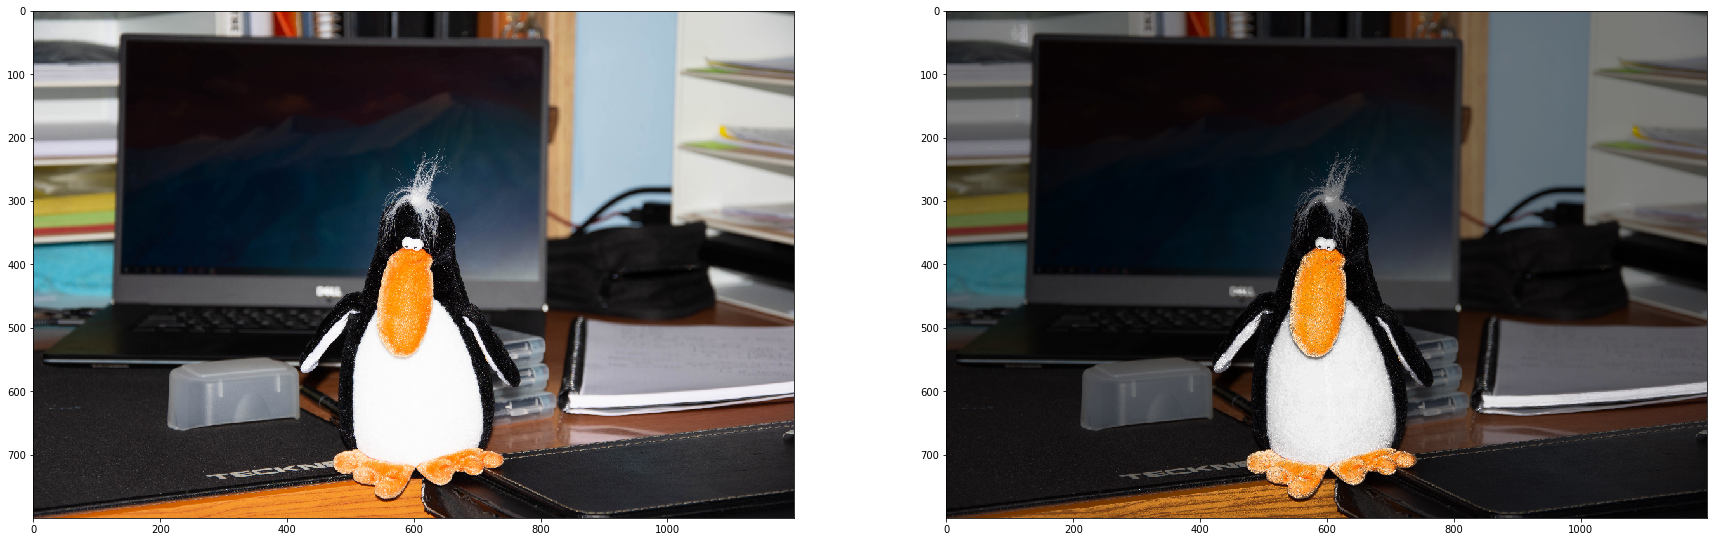

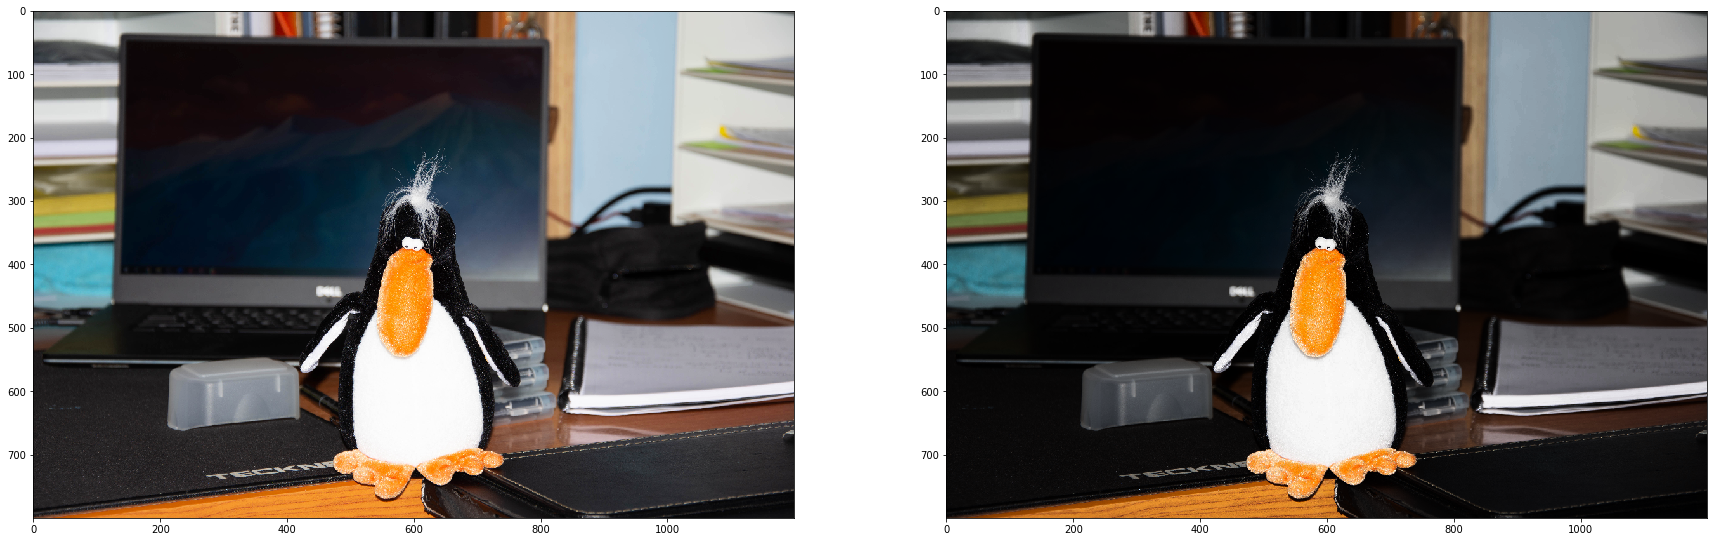

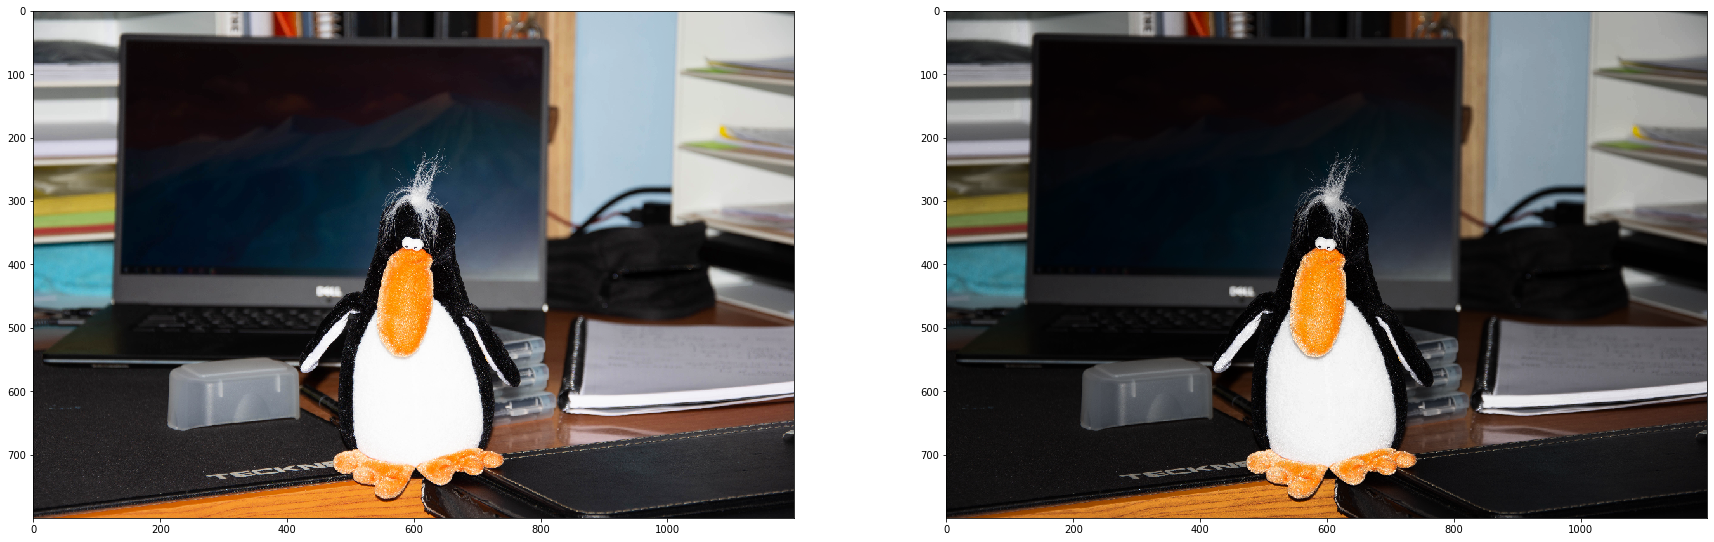

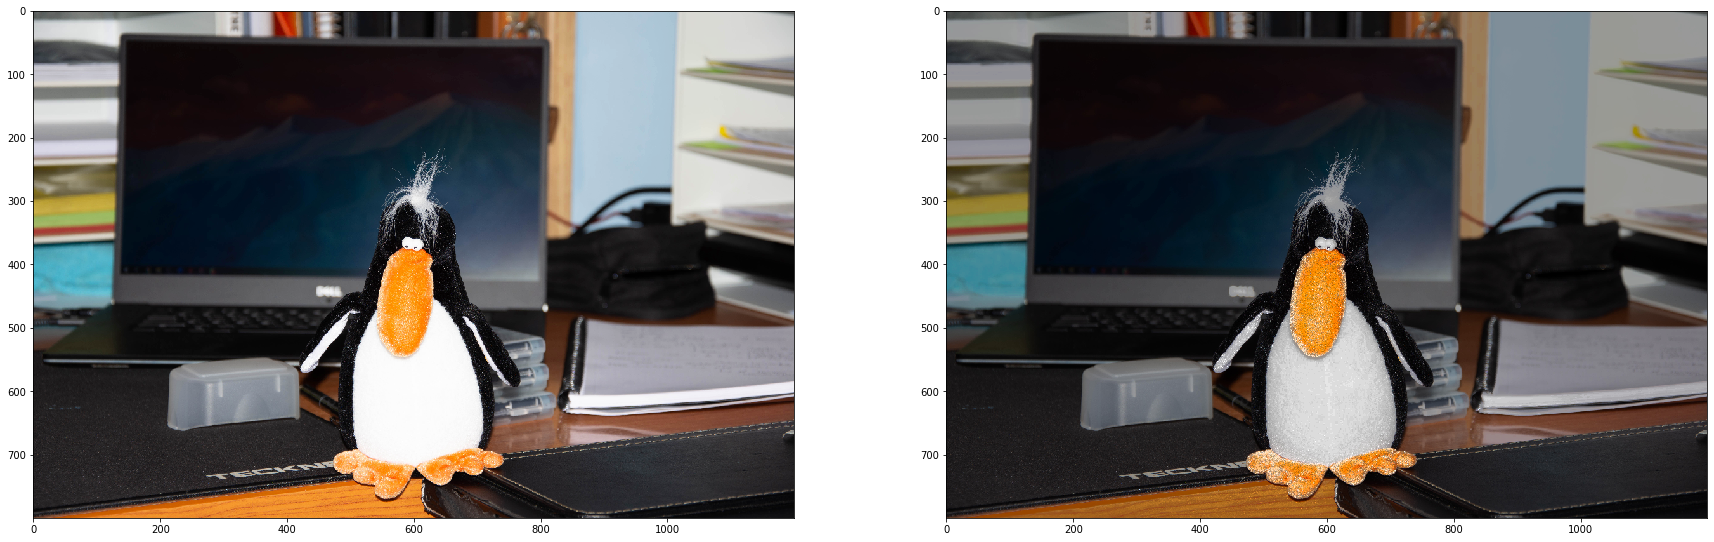

In [6]:
def transform(img,kernel,*args,show=True): 
    """
    Se le pasa, la imagen en HSV normalizado, el kernel, los argumentos del kernel en orden, y si quieres que compare el resultado con el oringinal
    """
    nx,ny,nz=img.shape
    out=np.copy(img)
    for x in range(nx):
        for y in range(ny):
            out[x,y,2]=kernel(img[x,y,2],*args)
    if show:
        fig, axs = plt.subplots(1,2,figsize=(30,20))
        axs[1].imshow(cv2.cvtColor(denorm_hsv(out), cv2.COLOR_HSV2RGB))
        axs[0].imshow(cv2.cvtColor(denorm_hsv(img), cv2.COLOR_HSV2RGB))
    return out

img=load_img(Imgfile,show=False)

print("Prueba doble recta")
output=transform(img,kernel_doble_recta,0.9,0.5)
print("Prueba exponencial")
output=transform(img,kernel_exp,10,1,1)
print("Prueba logaritmo")
output=transform(img,kernel_log,-2,1,1)
print("Prueba exponencial mas recta")
output=transform(img,kernel_exp_recta,1E+15,0.75,0.6,1,1)